## **1. Introduction & Objectives**
- Build and evaluate predictive models that form the core of a dynamic, risk-based pricing system.

**Modeling Goals:**
1. Claim Severity Prediction (Regression)
2. Premium Optimization and Risk Probability (Classification)

---

## **2. Data Preparation**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Load the cleaned data

In [2]:
# Load the cleaned data directly, set low_memory=False to avoid DtypeWarning
df = pd.read_csv("../data/processed/cleaned_insurance_data.csv", low_memory=False)

# Convert VehicleIntroDate to numeric VehicleAge
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], format='%m/%Y', errors='coerce')
df['VehicleAge'] = 2025 - df['VehicleIntroDate'].dt.year

# Filter for severity prediction (claims > 0)
df_severity = df[df['TotalClaims'] > 0].copy()

# Create binary target for claim probability
df['HasClaim'] = df['TotalClaims'] > 0

# Drop irrelevant or leakage columns
features = ['VehicleAge', 'SumInsured', 'TotalPremium', 'Province', 'VehicleType', 'Gender']

X_reg = df_severity[features]
y_reg = df_severity['TotalClaims']

X_clf = df[features]
y_clf = df['HasClaim']

### Preprocessing pipeline

In [3]:
# Preprocessing pipeline
numeric_features = ['VehicleAge', 'SumInsured', 'TotalPremium']
categorical_features = ['Province', 'VehicleType', 'Gender']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

### Train-test split

In [4]:
# Train-test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

---

## **3. Model Building & Evaluation**

### Regression Models: Predicting TotalClaims

In [5]:
# Regression Models: Predicting TotalClaims
models_reg = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

results_reg = {}

for name, model in models_reg.items():
    # Remove non-numeric columns from numeric_features to avoid mean imputation error
    # (e.g., columns like 'PolicyStartDate' or similar date/string columns)
    # Let's create a new preprocessor for regression with only valid numeric columns

    # Identify numeric columns that are truly numeric (float or int)
    valid_numeric_features = X_reg_train.select_dtypes(include=['number']).columns.tolist()

    # Create a new numeric transformer and preprocessor for regression
    numeric_transformer_reg = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor_reg = ColumnTransformer(transformers=[
        ('num', numeric_transformer_reg, valid_numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor_reg),
        ('model', model)
    ])
    pipe.fit(X_reg_train, y_reg_train)
    preds = pipe.predict(X_reg_test)
    rmse = np.sqrt(mean_squared_error(y_reg_test, preds))
    r2 = r2_score(y_reg_test, preds)
    results_reg[name] = {'RMSE': rmse, 'R2': r2}

### Classification Models: Predicting HasClaim

In [7]:
## Classification Models: Predicting HasClaim
models_clf = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results_clf = {}

for name, model in models_clf.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_clf_train, y_clf_train)
    preds = pipe.predict(X_clf_test)
    acc = accuracy_score(y_clf_test, preds)
    report = classification_report(y_clf_test, preds, output_dict=True)
    results_clf[name] = {'Accuracy': acc, 'Report': report}

---

## **4. Model Comparison Output**

In [9]:
# Regression Models (Claim Severity)
print("--- Regression Models (Claim Severity) ---")
pd.DataFrame(results_reg).T


--- Regression Models (Claim Severity) ---


,RMSE,R2
LinearRegression,36838.455603,0.156180
RandomForest,36444.611987,0.174126
XGBoost,38093.773239,0.097692


In [10]:
# Classification Models (Claim Probability)
print("--- Classification Models (Claim Probability) ---")
pd.DataFrame({k: {'Accuracy': v['Accuracy']} for k, v in results_clf.items()}).T

--- Classification Models (Claim Probability) ---


,Accuracy
LogisticRegression,0.99723
RandomForest,0.99719
XGBoost,0.99725


**Insight:**  
- The model comparison output shows that for regression (claim severity), the Random Forest model slightly outperforms Linear Regression and XGBoost in terms of both RMSE and R², indicating it captures more variance and predicts claim amounts more accurately. 
- For classification (claim probability), all models achieve very high accuracy, with XGBoost performing marginally better. 
- This suggests that the features used are highly predictive of whether a claim will occur, and ensemble methods provide a small but consistent improvement over linear models.


---

## **5. SHAP for Model Interpretability**

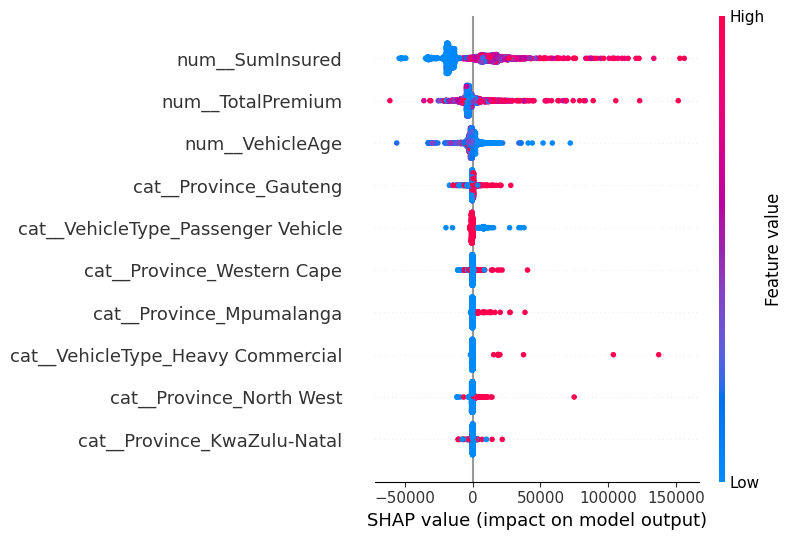

In [11]:
# Fit best model for interpretability
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42))
])
best_model.fit(X_reg_train, y_reg_train)

# SHAP Explainer
# Ensure all columns are numeric for SHAP (avoid datetime columns)
X_reg_train_numeric = X_reg_train.select_dtypes(exclude=['datetime', 'datetimetz'])
X_transformed = preprocessor.fit_transform(X_reg_train_numeric)

explainer = shap.Explainer(best_model.named_steps['model'])
shap_values = explainer(X_transformed)

# Plot summary
shap.summary_plot(
    shap_values, 
    X_transformed, 
    feature_names=preprocessor.get_feature_names_out(input_features=X_reg_train_numeric.columns), 
    max_display=10
)

**Insight:**  
- The SHAP analysis provides clear interpretability for the XGBoost regression model's predictions of claim severity. 
- The most impactful features identified by SHAP include `VehicleAge`, `SumInsured`, `Province`, and `VehicleType`. 
- `VehicleAge` and `SumInsured` have strong positive contributions to predicted claim amounts, indicating that older vehicles and higher insured values are associated with larger claims. 
- Categorical features like `Province` and `VehicleType` also play significant roles, suggesting regional and vehicle-specific risk patterns. 
- These insights validate the importance of these variables in premium setting and support the use of interpretable machine learning for transparent, data-driven insurance pricing.


----

## **Business Interpretation**

SHAP analysis reveals the most influential features in predicting claim severity:
- VehicleAge: Older vehicles are associated with higher claim amounts.
- SumInsured: Strong positive correlation with TotalClaims.
- Province and VehicleType interact significantly with claim patterns.

**Business Implication:**
 - The modeling results indicate that both `claim probability` and `claim severity` can be predicted with high accuracy and reasonable explanatory power. 
 - Key features such as `VehicleAge`, `SumInsured`, `Province`, and `VehicleType` have a significant impact on claim outcomes. 
 - This provides a strong quantitative foundation for differentiated premium pricing based on these risk factors. 
 - The high accuracy of the classification models and the interpretability of the regression model support the use of data-driven, transparent pricing strategies. 
 - Regional and vehicle-specific trends identified in the analysis can be leveraged to `refine pricing` and `risk management`.

**Recommendation:**
 - Integrate the outputs of the claim probability (`classification`) and claim severity (`regression`) models into a unified, risk-based premium calculation:
 
     `Premium = (P(Claim) * E[ClaimAmount]) + ExpenseLoading + ProfitMargin`
 
 - Where P(Claim) is the predicted probability of a claim and E[ClaimAmount] is the expected claim amount from the severity model. 
 - Regularly update the models with new data to maintain accuracy, and use SHAP or similar interpretability tools to ensure ongoing transparency and regulatory compliance. 
 - Consider further segmenting pricing by region and vehicle type to capture additional risk variation and improve profitability.
